In [1]:
# ** CHEQUEAR QUÉ LIBRERIAS ESTOY Y NO ESTOY USANDO** 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pip install plotly
import plotly.express as px
from scipy.interpolate import interp1d

from scipy import stats
import seaborn as sns
from scipy import signal
from sklearn.linear_model import LinearRegression

In [9]:
dust_file='Dust records uniformes e interpolados 16-05-22.xlsx'  #Base de datos sin valores repetidos, Uniforme
temp_file='Temps records uniformes e interpolados con Sambao.xlsx' #Base de datos sin valores repetidos, No uniforme

id_columns=['Name','Data id','Latitud','Longitud','Age units','Data units']

id_data=pd.read_excel(dust_file,sheet_name=0,usecols=id_columns)
#id_data=pd.read_excel(temp_file,sheet_name=0,usecols=id_columns)
#id_data.head()

df_data=pd.read_excel(dust_file,sheet_name=1,skiprows=1)
#df_data=pd.read_excel(temp_file,sheet_name=1,skiprows=1)

df_data.head()

,Year,DustFlux,Year.1,DustFlux.1,Year.2,nssCa2 flux,Year.3,Ca2+,Year.4,Lithogenic,...,Year.8,DustFlux.5,Year.9,MAR,Year.10,DustConc,Year.11,Ca2+.1,Year.12,Part conc
0,4.509000,513.3435,0.375,0.259,1.199480,150.00,3.791000,0.866667,0.620575,6.380517,...,1.150000,238095.240,0.0,10.72,5.00,305.363666,7.800600,10.8,10.147900,61.5565
1,6.220582,384.7395,0.400,0.329,1.520704,102.60,3.803001,1.550000,0.953589,7.436243,...,3.521513,271867.615,2.0,10.40,5.05,471.395055,8.421761,6.8,10.224514,71.9120
2,7.932164,860.8440,0.425,0.652,1.841928,189.80,3.815003,0.838333,1.286602,7.695384,...,5.893027,297619.050,4.0,8.57,5.10,266.747998,9.042922,6.0,10.301128,52.3480
3,9.643746,879.1290,0.450,0.341,2.163152,140.65,3.827004,1.428571,1.619615,6.968319,...,8.264540,229386.625,6.0,7.80,5.15,252.657484,9.664084,7.6,10.377742,45.4695
4,11.355328,755.5000,0.475,0.312,2.484376,164.40,3.839006,0.991667,1.952628,7.828854,...,10.636053,197878.860,8.0,7.98,5.20,338.667402,10.285245,7.2,10.454356,51.2840


In [10]:
#SEPARAR CADA UNA DE LAS COLUMNAS v.2
columns=df_data.size/len(df_data)
lis=[] 
new_length=np.array([])

for i in range(int(columns)):
    if (i+1)%2==1: 
        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna()
        dupla.index=[j for j in range(0, len(dupla))]
        lis.append(dupla)
        new_length=np.append(new_length,np.shape(dupla)[0])

## Correlaciones

#### El pairwise esta funcionando bien, sin duda. El "conjunto" esta comparando igual que 1 a 1 pero para un año límite común, tengo la duda si dejarlo así o si cambiar para que se evaluen "los mismos años" para todos... que creo que es más sintético la verdad.

In [5]:
def correlation(age1,values1,age2,values2,min_age=False,plot=False):
    #Defino el minimo periodo de tiempo común a ambos, y acoto las bases a esta extensión.    
    if min_age==False:
        min_common_age=min(max(age1),max(age2))
    else:
        min_common_age=min_age
    
    values1=values1[age1<=min_common_age]
    values2=values2[age2<=min_common_age]
    age1=age1[age1<=min_common_age]
    age2=age2[age2<=min_common_age]
        
    #defino cual es la más larga para luego interpolar sobre ella
    if len(age1)<=len(age2):
        x1 = np.array(age1)
        y1 = np.array(values1)
        x2 = np.array(age2)
        y2 = np.array(values2)
    if len(age2)<len(age1):
        x1 = np.array(age2)
        y1 = np.array(values2)
        x2 = np.array(age1)
        y2 = np.array(values1) 
    min_x1=min(x1)
    min_x2=min(x2)
    max_x1=max(x1)
    max_x2=max(x2)
    #defino el punto de inicio y detención de la interpolación
    if min_x2<=min_x1:
        starting_point=min_x1
        inicial1=0
        
    if min_x2>min_x1:
        encontrado=False
        indice=0
        while encontrado==False:
            if x1[indice]>=min_x2:
                starting_point=x1[indice]
                encontrado=True
                inicial1=indice
            else:
                indice+=1    
        
    if max_x2>=max_x1:
        stopping_point=max_x1
        final1=len(x1)
        
    if max_x2<max_x1:
        encontrado2=False
        indice2=1
        while encontrado2==False:
            if x1[-indice2]<=max_x2:
                stopping_point=x1[-indice2]
                encontrado2=True
                final1=len(x1)-indice2
            else:
                indice2+=1   
    
    f2=interp1d(x2, y2, kind='linear')
    interpolado=f2(x1[inicial1:final1])
    
    #Normalizo
    y1=(y1-y1.mean())/y1.std()
    y2=(y2-y2.mean())/y2.std()
    interpolado=(interpolado-interpolado.mean())/interpolado.std()
    #print(len(interpolado))
    #corr=np.corrcoef(y1[inicial1:final1],interpolado)[0][1]   #Pearsons correlation coefficient
    corr=stats.spearmanr(y1[inicial1:final1],interpolado)[0] #Spearman correlation coefficient
    
        
    #Graficamente
    if plot=='plot':    
        fig, ax = plt.subplots(1,1)
        fig.set_figwidth(16)
        plt.plot(x1,y1,'-',label='X1 (shorter)')
        plt.plot(x2,y2,'--',label='X2 (longer)',color='y')
        plt.plot(x1[inicial1:final1],interpolado,'o',label='Y2(x1)',color='g') #interpolo x2, por eso tiene que ser el largo!
        plt.legend()
        plt.axvline(starting_point,color='red',linestyle='--',linewidth=0.5)
        plt.axvline(stopping_point,color='red',linestyle='--',linewidth=0.5)
        plt.show()
        
    return corr

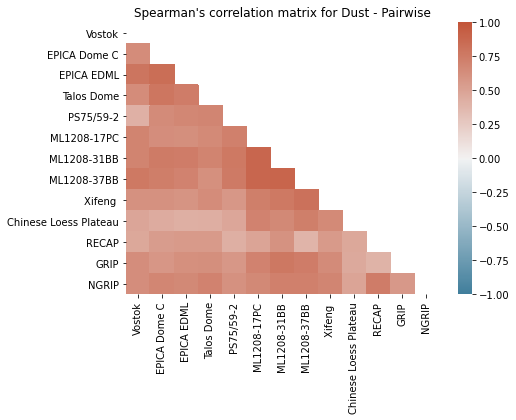

In [12]:
coef_matrix=np.zeros((len(lis),len(lis)))
names=[]
for i in range(len(lis)):
    names.append(id_data['Name'][i])
    for j in range(len(lis)):
        coef_matrix[i][j]=correlation(lis[i][lis[i].columns[0]],lis[i][lis[i].columns[1]],lis[j][lis[j].columns[0]],lis[j][lis[j].columns[1]])
        #coef_matrix[i][j]=correlation(common_ages[i],normalized_common_values[i],common_ages[j],normalized_common_values[j])
        
corr=pd.DataFrame(coef_matrix,columns=names,index=names)

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, mask=mask, cmap=cmap,vmax=1,vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap,vmax=1,vmin=-1, center=0)

plt.title('Spearman\'s correlation matrix for Dust - Pairwise')
plt.savefig('Spearman correlacion 1 a 1 Dust.pdf',bbox_inches='tight')


plt.show()

In [41]:
#len(lis)
#lis.pop(5)


207
207
207
207
205
206
149
148
79
51
204
198
195
207
4231
4197
4095
484
380
149
148
82
53
2060
788
1916
207
4197
106781
13892
481
380
149
148
81
53
2060
788
1916
207
4095
13892
13892
469
380
149
148
79
52
2060
788
1916
205
484
481
469
484
378
149
148
80
53
464
449
441
206
380
380
380
378
380
149
148
79
51
377
367
360
149
149
149
149
149
149
149
147
75
50
149
148
144
148
148
148
148
148
148
147
148
75
50
148
146
142
79
82
81
79
80
79
75
75
82
53
79
74
75
51
53
53
52
53
51
50
50
53
54
51
50
48
204
2060
2060
2060
464
377
149
148
79
51
2060
788
1916
198
788
788
788
449
367
148
146
74
50
788
788
769
195
1916
1916
1916
441
360
144
142
75
48
1916
769
1918


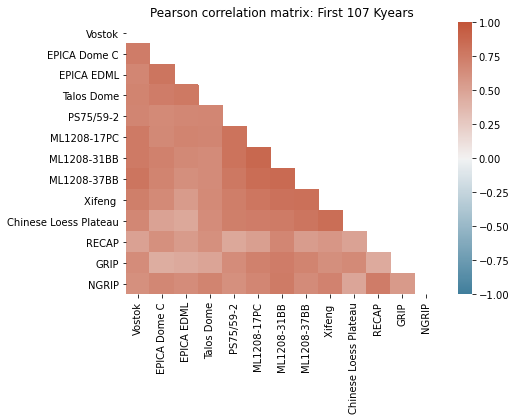

In [6]:
#defino el minimo año
time_span=np.array([])
for i in range(len(lis)):
    time_span=np.append(time_span,max(lis[i][lis[i].columns[0]]))
min_common_age=min(time_span)


coef_matrix=np.zeros((len(lis),len(lis)))
names=[]
for i in range(len(lis)):
    names.append(id_data['Name'][i])
    for j in range(len(lis)):
        coef_matrix[i][j]=correlation(lis[i][lis[i].columns[0]],lis[i][lis[i].columns[1]],lis[j][lis[j].columns[0]],lis[j][lis[j].columns[1]],min_common_age)
        #coef_matrix[i][j]=correlation(common_ages[i],normalized_common_values[i],common_ages[j],normalized_common_values[j])
        
corr=pd.DataFrame(coef_matrix,columns=names,index=names)

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(230, 20,as_cmap=True)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0)

#plt.title('Spearman correlation matrix: First '+str(int(min_common_age))+' Kyears')
#plt.savefig('Spearman correlacion comun 59ky .jpg',bbox_inches='tight')

plt.title('Pearson correlation matrix: First '+str(int(min_common_age))+' Kyears')
#plt.savefig('Pearson correlacion comun dust.jpg',bbox_inches='tight')

plt.show()